In [1]:
import sys
sys.path.extend(['/users/students/r0749898/thesis/'])

In [2]:
import os
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

from datasets.SHHS_dataset_timeonly import SHHS_dataset_1, EEGdataModule

from models.simclr_model import SimCLR
from models.supervised_model import SupervisedModel
import torch
import torch.utils.data as data
#import matplotlib.pyplot as plt
import numpy as np
#from sklearn.manifold import TSNE
#import seaborn as sns
#import pandas as pd
from argparse import Namespace
from copy import deepcopy
from utils.helper_functions import load_model, SimCLRdataModule

## Define dataset: 10 patients for training, 5 for validation and 30 for testing


In [19]:
data_args = {
  "DATA_PATH": "/esat/biomeddata/SHHS_Dataset/no_backup/",
  "data_split": [2, 1],
  "first_patient": 1,
  "num_patients_train": 3,
  "num_patients_test": 30,
  "batch_size": 64,
  "num_workers": 12
}

dm = EEGdataModule(**data_args)  # Load datamodule
dm.setup()

Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0014_eeg.mat


In [20]:
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(device)

cuda:0


## Run data through the pretrained SimCLR encoder to get the representations
- The SimCLR model was pretrained on 100 patients (+50 for validation)

In [21]:
encoder_path = "../trained_models/cnn_simclr01.ckpt"
pretrained_model = load_model(SimCLR, encoder_path)  # Load pretrained simclr model
simclr_dm = SimCLRdataModule(pretrained_model, dm, data_args['batch_size'], data_args['num_workers'], device)

/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
  rank_zero_warn(


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/434 [00:00<?, ?it/s]

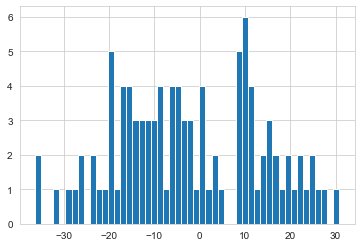

In [6]:
## Analyse the features: histogram and t-SNE plot
feature = next(iter(simclr_dm.train_dataloader()))[0][0]
plt.hist(np.asarray(feature), bins=50)
plt.show()

In [ ]:
tsne = TSNE(n_components=2, n_iter=300, verbose=1, perplexity=125)
x = torch.cat(list(dm.train_dataloader())[0])
x, y = train_ds.tensors
tsne_results = tsne.fit_transform(x)

In [ ]:
df = pd.DataFrame()
df['comp-1'] = tsne_results[:,0]
df['comp-2'] = tsne_results[:,1]
df["y"] = y
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x="comp-1", y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

## Train a logistic classifier on top


In [22]:
logistic_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "logistic_on_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "None",
  "encoder_hparams": {},

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 15
  },
  "optim_hparams": {
    "lr": 1e-3,
    "weight_decay": 1e-4
  }
}
from trainers.train_supervised import train_supervised
model, res = train_supervised(Namespace(**logistic_args), device=device, dm=simclr_dm)
print(res)

Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | Sequential       | 505   
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
505       Trainable params
0         Non-trainable params
505       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/users/students/r0749898/miniconda3/envs/newthesisenv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

{'test': 0.6281322240829468, 'val': 0.7627659440040588}


## Train a supervised model with the same dataset for comparison


In [23]:
supervised_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "supervised_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 15
  },
  "optim_hparams": {
    "lr": 1e-3,
    "weight_decay": 1e-4
  }
}
sup_model, sup_res = train_supervised(Namespace(**supervised_args), device, dm=dm)
print(sup_res)

Global seed set to 42


Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0014_eeg.mat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: checkpoints/supervised_simclr/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | Sequential       | 2.4 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

{'test': 0.5822652578353882, 'val': 0.6691489219665527}


## Finetuned supervised model

In [24]:
finetune_args = {
  "MODEL_TYPE": "SupervisedModel",
  "save_name": "finetuned_simclr",
  "DATA_PATH": data_args['DATA_PATH'],
  "CHECKPOINT_PATH": "checkpoints",

  "encoder": "CNN_head",
  "encoder_hparams": {
    "conv_filters": [32, 64, 64],
    "representation_dim": 100
  },

  "classifier": "logistic",
  "classifier_hparams":{
      "input_dim": 100
  },
  "data_hparams": data_args,

  "trainer_hparams":{
    "max_epochs": 30
  },
  "optim_hparams": {
    "lr": 1e-5,
    "weight_decay": 5e-4
  }
}
pretrained_encoder = type(pretrained_model.f)(**finetune_args['encoder_hparams'])
pretrained_encoder.load_state_dict(pretrained_model.f.state_dict())
fine_tuned_model, fine_tuned_res = train_supervised(Namespace(**finetune_args), device, dm=dm, pretrained_encoder=pretrained_encoder)
print(fine_tuned_res

Global seed set to 42


Couldn't find file at path:  /esat/biomeddata/SHHS_Dataset/no_backup/n0014_eeg.mat


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params
-------------------------------------------------
0 | net         | Sequential       | 2.4 M 
1 | loss_module | CrossEntropyLoss | 0     
-------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.678     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

{'test': 0.6511016488075256, 'val': 0.707446813583374}


In [17]:
list(fine_tuned_model.net.parameters())

[Parameter containing:
 tensor([[[-0.0618,  0.1018,  0.3921]],
 
         [[ 0.3342, -0.2160,  0.2837]],
 
         [[-0.5094, -0.3805,  0.3898]],
 
         [[-0.4753,  0.5017,  0.2955]],
 
         [[ 0.1219, -0.2181,  0.3785]],
 
         [[ 0.0081, -0.3483,  0.0327]],
 
         [[-0.4251,  0.0202, -0.0413]],
 
         [[-0.0915, -0.2661, -0.5534]],
 
         [[-0.1167, -0.3266, -0.0709]],
 
         [[ 0.4587,  0.3592,  0.4250]],
 
         [[ 0.2044, -0.1736,  0.0798]],
 
         [[ 0.2287,  0.3876,  0.1574]],
 
         [[-0.2506,  0.4226, -0.2369]],
 
         [[-0.2224,  0.0278, -0.2675]],
 
         [[ 0.3853,  0.0382, -0.5315]],
 
         [[ 0.3164, -0.4914, -0.0316]],
 
         [[-0.3309, -0.0431, -0.4434]],
 
         [[ 0.0221,  0.3741, -0.3568]],
 
         [[-0.1419,  0.1736, -0.1830]],
 
         [[-0.1650,  0.0924,  0.5956]],
 
         [[-0.4629,  0.1117, -0.4572]],
 
         [[-0.3489, -0.0095,  0.5174]],
 
         [[-0.2261, -0.0417, -0.2169]],
 
         [[